# Machine Learning Model
Matheus Miranda Brandão

## Imports

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

## Observações inicias

Importar os dados.

In [159]:
df = pd.read_csv('../../datasets/raw/training_data.csv', sep=';')
df.head(1)

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,25,Travel_Rarely,685,Research & Development,1,3,Life Sciences,1,350,1,...,80,2,5,3,3,4,2,1,2,0


Por conversão pessoal, foi redefinido o padrão de nomeação de colunas para snake_case.

In [160]:
def camel_to_snake(col: str) -> str:
    col = ''.join([item if not item.isupper() else '_' + item for item in col])
    return col[1:].lower()

for item in df.columns:
    df.rename(columns={item: camel_to_snake(item)}, inplace=True)
del camel_to_snake
    
df.business_travel.replace(r'_', ' ', regex=True, inplace=True)

In [161]:
# A coluna Over18 só tem um valor, então não é relevante para o modelo
df.drop(columns=['over18'], inplace=True)
# As colunas EmployeeCount e StandardHours só tem um valor, então não é relevante para o modelo
df.drop(columns=['employee_count', 'standard_hours'], inplace=True)
# A coluna EmployeeNumber é apenas um identificador, então não é relevante para o modelo
df.drop(columns=['employee_number'], inplace=True)

In [162]:
df.sample(5)

,age,business_travel,daily_rate,department,distance_from_home,education,education_field,environment_satisfaction,gender,hourly_rate,...,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager,attrition
1046,38,Non-Travel,1327,Sales,2,2,Life Sciences,4,Male,39,...,4,1,13,0,3,8,7,7,5,0
512,33,Travel Rarely,217,Sales,10,4,Marketing,2,Male,43,...,2,0,10,2,2,10,4,0,9,0
343,37,Travel Rarely,1017,Research & Development,1,2,Medical,3,Female,83,...,1,1,17,2,2,3,1,0,2,0
635,37,Travel Rarely,1305,Research & Development,10,4,Life Sciences,3,Male,49,...,4,0,18,2,2,1,0,0,1,0
764,35,Travel Rarely,1490,Research & Development,11,4,Medical,4,Male,43,...,3,1,5,3,3,2,2,2,2,0


Mudança de do d_type dos dados para otimização do uso de memória

In [163]:
for item in df.select_dtypes('object').columns:
    df[item] = df[item].astype('category')
    
for item in df.select_dtypes('number').columns:
    ok = (df[item] == df[item].astype('int8')).unique()
    if len(ok) == 1:
        df[item] = df[item].astype('int8')
    else:
        df[item] = df[item].astype('int16')

Algumas colunas possuem ordem ou são binárias, portanto, serão tratadas com o LabelEncoder.

```python
'business_travel'
'gender'
'over_time'
```

In [164]:
for item in ['business_travel', 'gender', 'over_time']:
    df[item] = LabelEncoder().fit_transform(df[item])

Um problema foi identificado nesse dataset. A coluna attrution(target) possui um desbalanceamento muito grande, o que pode causar um viés no modelo. Para resolver esse problema, será utilizada uma técnica para balancear os dados.

In [165]:
df.attrition.value_counts(normalize=True)

attrition
0    0.838435
1    0.161565
Name: proportion, dtype: float64

## Balanceamento do dataset

Para o balanceamento do dataset foi utilizada duas técnicas em conjunto:
- Random Under-Sampling with Replacement (RUS)
- Random Over-Sampling with Replacement (ROS)

A ideia é reduzir o número de exemplos da classe majoritária e aumentar o número de exemplos da classe minoritária de forma aleatória, para que as classes fiquem mais equilibradas.

Ao final temos uma distribuição de aproximadamente 60/40.

In [166]:
def balance_dataset(df: pd.DataFrame, target: str, percentual=.45) -> pd.DataFrame:
    df_balanced = df.copy()
    while True:
        majority, minority = df_balanced[target].value_counts(normalize=True).index.to_list()
        
        if np.random.randint(2): # Maioria
            idx = df_balanced[df_balanced[target] == majority].sample(1).index
            df_balanced.drop(index=idx, inplace=True)
            df_balanced.reset_index(drop=True, inplace=True)
        else: # Minoria
            idx = df[df[target] == minority].sample(1).index
            df_balanced = pd.concat([df_balanced, df.iloc[idx, :]], ignore_index=True)
        
        if percentual-.05 < df_balanced[target].value_counts(normalize=True).values[1] <= percentual+.05:
            break
        
    return df_balanced

Para reprodução posterior dos experimentos foi salvo o dataset balanceado em um arquivo pkl.

In [167]:
# df_balanced = balance_dataset(df, 'attrition')
df_balanced = pd.read_pickle('../../datasets/processed/balanced_dataset.pkl')

## Preparação dos dados e Experimentos iniciais

In [168]:
results = {
    'LogisticRegression': [],
    'KNN': [],
    'RandomForest': []
}

Separação do X e y.

In [169]:
features = df_balanced.drop(columns=['attrition'])
target = df_balanced.attrition

Para uso do Pipeline e ColumnTransformer, foi separada as colunas por tipo de dado.

Criação do Pipeline para transformação dos dados.

In [170]:
def create_model(model, features: pd.DataFrame, scaler=True) -> Pipeline:
    categorical = features.select_dtypes(include='category').columns.to_list()
    cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))])
    
    transformers=[ ('cat', cat_transformer, categorical) ]
    
    if scaler:
        numerical = features.select_dtypes(include='number').columns.to_list()
        num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        transformers.insert(0, ('num', num_transformer, numerical))
    
    preprocessor = ColumnTransformer(transformers=transformers)
    
    return Pipeline( steps = [ ('preprocessor', preprocessor), ('estimator', model) ] )

Separação dos dados em treino e teste, utilizando o preceito de amostragem estratificada.

In [171]:
def create_train(features: pd.DataFrame, target: pd.Series) -> tuple:
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)
    return x_train, x_test, y_train, y_test

In [172]:
x_train, x_test, y_train, y_test = create_train(features, target)

In [173]:
model = create_model(LogisticRegression(random_state=42), features)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

results['LogisticRegression'].append(cross_val_score(model, features, target, cv=5, scoring='recall'))

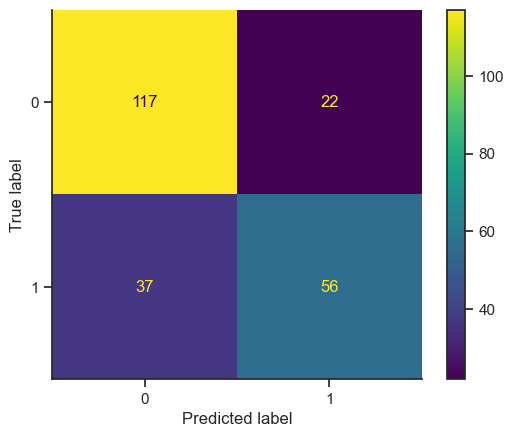

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       555
           1       0.75      0.70      0.72       370

    accuracy                           0.79       925
   macro avg       0.78      0.77      0.77       925
weighted avg       0.78      0.79      0.78       925


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       139
           1       0.72      0.60      0.65        93

    accuracy                           0.75       232
   macro avg       0.74      0.72      0.73       232
weighted avg       0.74      0.75      0.74       232



In [174]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

In [175]:
model = create_model(KNeighborsClassifier(), features)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

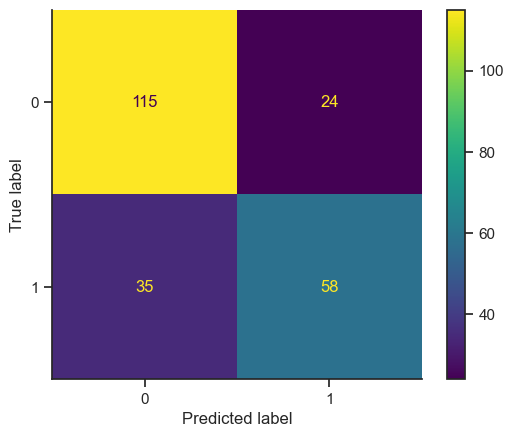

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       555
           1       0.83      0.78      0.80       370

    accuracy                           0.85       925
   macro avg       0.84      0.84      0.84       925
weighted avg       0.85      0.85      0.85       925


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       139
           1       0.71      0.62      0.66        93

    accuracy                           0.75       232
   macro avg       0.74      0.73      0.73       232
weighted avg       0.74      0.75      0.74       232



In [176]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

results['KNN'].append(cross_val_score(model, features, target, cv=5, scoring='recall'))

In [177]:
model = create_model(RandomForestClassifier(), features)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

results['RandomForest'].append(cross_val_score(model, features, target, cv=5, scoring='recall'))

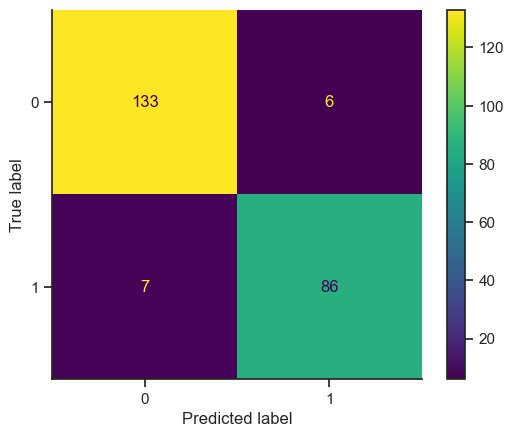

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       555
           1       1.00      1.00      1.00       370

    accuracy                           1.00       925
   macro avg       1.00      1.00      1.00       925
weighted avg       1.00      1.00      1.00       925


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       139
           1       0.93      0.92      0.93        93

    accuracy                           0.94       232
   macro avg       0.94      0.94      0.94       232
weighted avg       0.94      0.94      0.94       232



In [178]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

## Feature Selection

A partir da etapa de Análise Exploratória de Dados, foi possível identificar as variáveis que possuem maior correlação com o target.

Correlação entre o target e as variáveis (ordenadas de maneira crescente).

Variável | Correlação
--- | ---
business_travel | 0.004875
education | 0.014302
hourly_rate | 0.027314
performance_rating | 0.029702
years_since_last_promotion | 0.030815
percent_salary_hike | 0.035178
gender | 0.038926
education_field | 0.045544
department | 0.053268
monthly_rate | 0.055159
job_role | 0.057578
distance_from_home | 0.058465
relationship_satisfaction | 0.060555
training_times_last_year | 0.061844
monthly_income | 0.063097
work_life_balance | 0.068202
num_companies_worked | 0.068476
daily_rate | 0.068509
job_satisfaction | 0.092833
job_involvement | 0.116793
stock_option_level | 0.117032
years_at_company | 0.122297
environment_satisfaction | 0.123244
marital_status | 0.138290
age | 0.148860
years_in_current_role | 0.149864
years_with_curr_manager | 0.150635
total_working_years | 0.158067
job_level | 0.166499
over_time | 0.252677

In [179]:
corr_strong = ['over_time', 'job_level', 'total_working_years', 'years_with_curr_manager', 'years_in_current_role', 'age', 'marital_status', 'environment_satisfaction', 'years_at_company', 'stock_option_level', 'job_involvement', 'job_satisfaction', 'daily_rate', 'num_companies_worked', 'work_life_balance', 'monthly_income', 'training_times_last_year', 'relationship_satisfaction', 'distance_from_home', 'job_role', 'monthly_rate', 'department', 'education_field', 'gender', 'percent_salary_hike', 'years_since_last_promotion', 'performance_rating', 'hourly_rate', 'education']
corr_weak = corr_strong[-1:0:-1]

In [180]:
def learning_curve_of_feature(features: pd.DataFrame, target: pd.Series, var: list, model, tol=.7) -> tuple:
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)
    scaler = StandardScaler()
    score = {
        'Error_train': [],
        'Error_test': []
    }
    
    higher_in_train = [0, 0]
    higher_in_test = [0, 0]
    best_diff = [100, 0]
    
    for i in range(1, features.shape[1]+1):
        x_train_temp, x_test_temp = x_train[var[:i]], x_test[var[:i]]
        
        categorical = x_train_temp.select_dtypes(include='category').columns.to_list()
        x_train_temp = pd.get_dummies(x_train_temp, columns=categorical, drop_first=True)
        x_test_temp = pd.get_dummies(x_test_temp, columns=categorical, drop_first=True)
        x_train_temp = scaler.fit_transform(x_train_temp)
        x_test_temp = scaler.transform(x_test_temp)
        
        new_model = model
        new_model.fit(x_train_temp, y_train)
        y_pred_train = new_model.predict(x_train_temp)
        y_pred_test = new_model.predict(x_test_temp)
        
        error_train = f1_score(y_train, y_pred_train)
        error_test = f1_score(y_test, y_pred_test)
        
        if error_test > tol or error_train > tol: 
            if abs(error_train - error_test) < best_diff[0]: best_diff = [error_train - error_test, i] 
        if error_train > higher_in_train[0]:higher_in_train = [error_train, i]
        if error_test > higher_in_test[0]:higher_in_test = [error_test, i]
        
        score['Error_train'].append(error_train)
        score['Error_test'].append(error_test)
    
    score = pd.DataFrame(score)
    return score, higher_in_train, higher_in_test, best_diff

Análise da learning curve a partir das variáveis com maior correlação com o target.

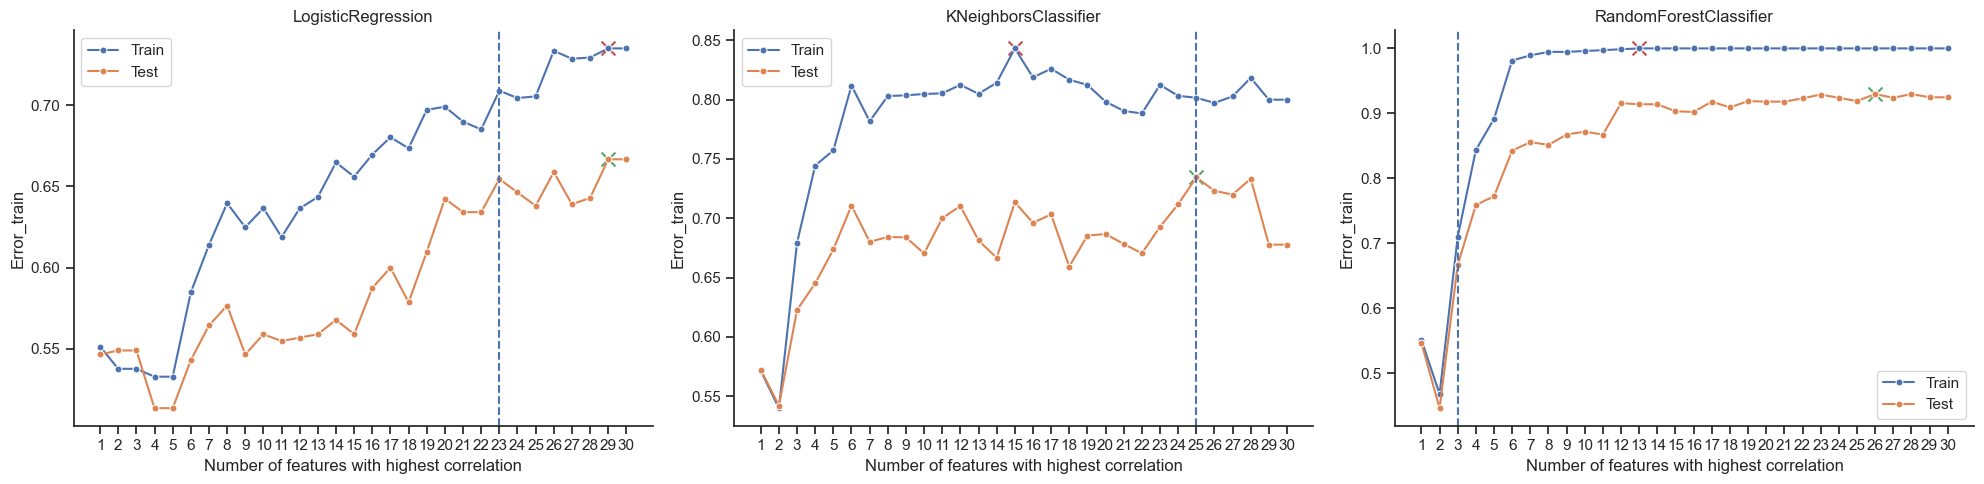

In [181]:
fig = plt.figure(figsize=(20, 5))

for i, model in enumerate([LogisticRegression(random_state=42), KNeighborsClassifier(), RandomForestClassifier(n_jobs=-1, random_state=42)]):
    ax = fig.add_subplot(1, 3, i+1)
    curve, higher_in_train, higher_in_test, best_diff = learning_curve_of_feature(features, target, corr_strong, model)
    x = np.arange(1, curve.shape[0]+1)
    sns.lineplot(data=curve, x=x, y='Error_train', marker= '.', markersize=10, ax=ax, label='Train')
    ax.scatter(higher_in_train[1], higher_in_train[0], color='r', marker='x', s=100)
    sns.lineplot(data=curve, x=x, y='Error_test', marker= '.', markersize=10, ax=ax, label='Test')
    ax.scatter(higher_in_test[1], higher_in_test[0], color='g', marker='x', s=100)
    plt.axvline(x=best_diff[1], color='b', linestyle='--')
    ax.set_xticks(x)
    ax.set_title(model.__class__.__name__)
    ax.set_xlabel('Number of features with highest correlation')
    ax.legend()
    fig.tight_layout()
plt.show()

Análise da learning curve a partir das variáveis com menor correlação com o target.

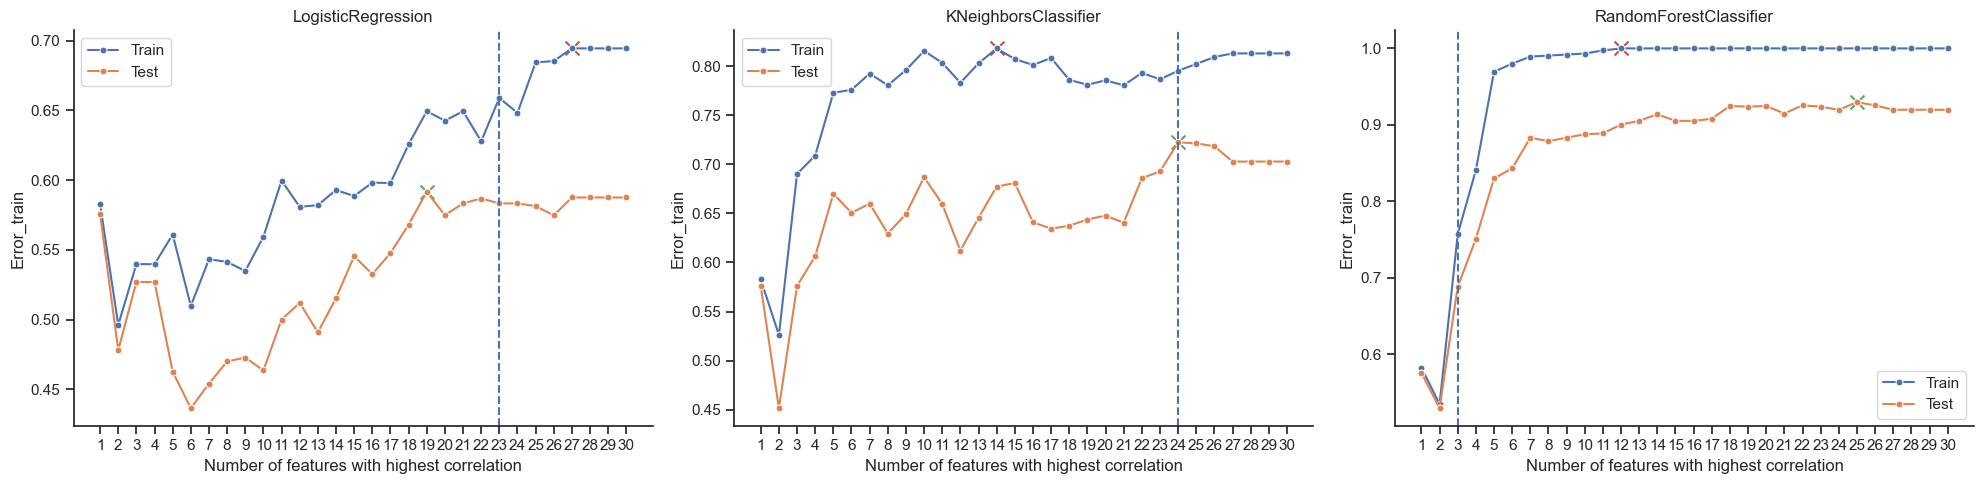

In [182]:
fig = plt.figure(figsize=(20, 5))

for i, model in enumerate([LogisticRegression(random_state=42), KNeighborsClassifier(), RandomForestClassifier(n_jobs=-1, random_state=42)]):
    ax = fig.add_subplot(1, 3, i+1)
    curve, higher_in_train, higher_in_test, best_diff = learning_curve_of_feature(features, target, corr_weak[-1:0:-1], model, tol=.65)
    x = np.arange(1, curve.shape[0]+1)
    sns.lineplot(data=curve, x=x, y='Error_train', marker= '.', markersize=10, ax=ax, label='Train')
    ax.scatter(higher_in_train[1], higher_in_train[0], color='r', marker='x', s=100)
    sns.lineplot(data=curve, x=x, y='Error_test', marker= '.', markersize=10, ax=ax, label='Test')
    ax.scatter(higher_in_test[1], higher_in_test[0], color='g', marker='x', s=100)
    plt.axvline(x=best_diff[1], color='b', linestyle='--')
    ax.set_xticks(x)
    ax.set_title(model.__class__.__name__)
    ax.set_xlabel('Number of features with highest correlation')
    ax.legend()
    fig.tight_layout()
plt.show()

A partir dos dados acima, foi possível identificar alguns pontos:
- Foram marcados os melhores scores para treino e ganho, e além disso a menor diferença entre eles.
- A escolha ideal de features depende do modelo que será utilizado.
- Random Forest tende a overfittar os dados.

## Testes com as novas features

In [183]:
logistic_features = features[corr_strong[:24]]
knn_features = features[corr_weak[:24]]
random_forest_features = features[corr_strong[:6]]

### Logistic Regression

In [184]:
x_train, x_test, y_train, y_test = create_train(logistic_features, target)

model = create_model(LogisticRegression(random_state=42), logistic_features)
model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

results['LogisticRegression'].append(cross_val_score(model, features, target, cv=5, scoring='recall'))

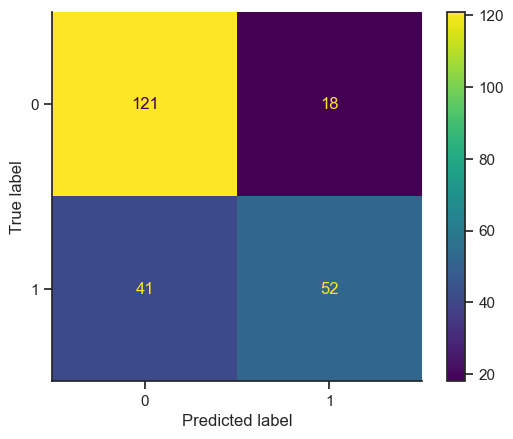

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       555
           1       0.74      0.65      0.70       370

    accuracy                           0.77       925
   macro avg       0.77      0.75      0.76       925
weighted avg       0.77      0.77      0.77       925


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.75      0.87      0.80       139
           1       0.74      0.56      0.64        93

    accuracy                           0.75       232
   macro avg       0.74      0.71      0.72       232
weighted avg       0.75      0.75      0.74       232



In [185]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

### KNN

In [186]:
x_train, x_test, y_train, y_test = create_train(knn_features, target)

model = create_model(KNeighborsClassifier(), knn_features)
model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

results['KNN'].append(cross_val_score(model, features, target, cv=5, scoring='recall'))

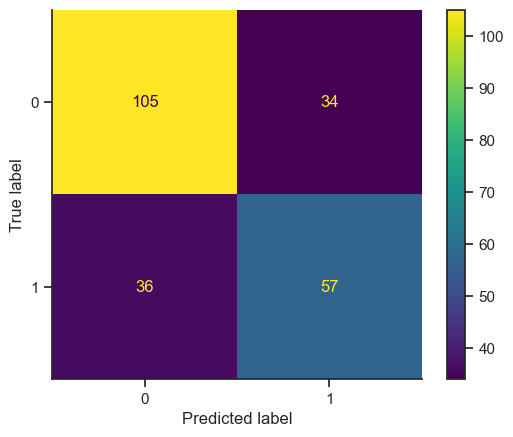

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       555
           1       0.79      0.76      0.78       370

    accuracy                           0.83       925
   macro avg       0.82      0.82      0.82       925
weighted avg       0.83      0.83      0.83       925


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       139
           1       0.63      0.61      0.62        93

    accuracy                           0.70       232
   macro avg       0.69      0.68      0.68       232
weighted avg       0.70      0.70      0.70       232



In [187]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

### Random Forest

In [188]:
x_train, x_test, y_train, y_test = create_train(random_forest_features, target)

model = create_model(RandomForestClassifier(n_jobs=-1, random_state=42), random_forest_features)
model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

results['RandomForest'].append(cross_val_score(model, features, target, cv=5, scoring='recall'))

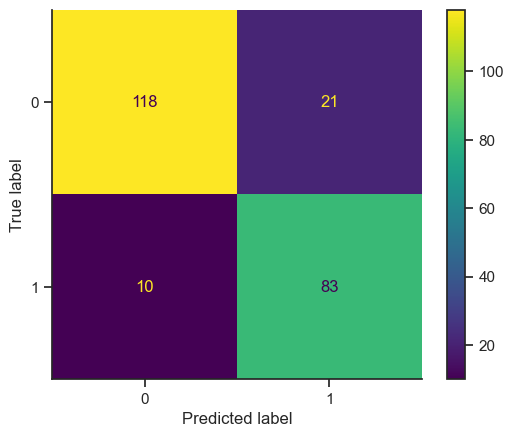

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       555
           1       0.97      0.99      0.98       370

    accuracy                           0.98       925
   macro avg       0.98      0.99      0.98       925
weighted avg       0.99      0.98      0.98       925


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       139
           1       0.80      0.89      0.84        93

    accuracy                           0.87       232
   macro avg       0.86      0.87      0.86       232
weighted avg       0.87      0.87      0.87       232



In [189]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

## Tuning dos hiperparâmetros

### Logistic Regression

In [190]:
# x_train, x_test, y_train, y_test = create_train(logistic_features, target)

# categorical = x_train.select_dtypes(include='category').columns.to_list()
# x_train_temp = pd.get_dummies(x_train, columns=categorical, drop_first=True)
# x_test_temp = pd.get_dummies(x_test, columns=categorical, drop_first=True)

# scaler = StandardScaler()
# x_train_temp = scaler.fit_transform(x_train_temp)
# x_test_temp = scaler.transform(x_test_temp)

In [191]:
# params = {
#     'penalty': ['l1', 'l2', 'elasticnet', None],
#     'dual': [True, False],
#     'tol': [1e-4, 1e-3, 1e-2],
#     'C': [0.1, 0.5, 1.0, 1.5, 2.0],
#     'fit_intercept': [True, False],
#     'solver': ['liblinear']
# }

# grid = GridSearchCV(LogisticRegression(random_state=42), param_grid=params, scoring='recall', cv=5, n_jobs=-1, verbose=1)
# grid.fit(x_train_temp, y_train)
# grid.best_params_

- C=1.0,
- dual=False,
- fit_intercept=False,
- penalty='l1',
- solver='liblinear',
- tol=0.0001

### KNN

In [192]:
# x_train, x_test, y_train, y_test = create_train(knn_features, target)

# categorical = x_train.select_dtypes(include='category').columns.to_list()
# x_train_temp = pd.get_dummies(x_train, columns=categorical, drop_first=True)
# x_test_temp = pd.get_dummies(x_test, columns=categorical, drop_first=True)

# scaler = StandardScaler()
# x_train_temp = scaler.fit_transform(x_train_temp)
# x_test_temp = scaler.transform(x_test_temp)

In [193]:
# params = {
#     'n_neighbors': np.arange(1, 100)
# }

# grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, scoring='recall', cv=5, n_jobs=-1, verbose=1)
# grid.fit(x_train_temp, y_train)
# grid.best_params_

- n_neighbors = 1

### Random Forest

In [194]:
# x_train, x_test, y_train, y_test = create_train(random_forest_features, target)

# categorical = x_train.select_dtypes(include='category').columns.to_list()
# x_train_temp = pd.get_dummies(x_train, columns=categorical, drop_first=True)
# x_test_temp = pd.get_dummies(x_test, columns=categorical, drop_first=True)

# scaler = StandardScaler()
# x_train_temp = scaler.fit_transform(x_train_temp)
# x_test_temp = scaler.transform(x_test_temp)

In [195]:
# params = {
#     'n_estimators': np.arange(100, 501, 100),
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'max_depth': np.arange(1, 10),
#     'min_samples_split': np.arange(2, 10),
#     'min_samples_leaf': np.arange(1, 5),
# }

# grid = RandomizedSearchCV(RandomForestClassifier(random_state=42), n_iter=500, param_distributions=params, scoring='recall', cv=5, n_jobs=-1, verbose=1)
# grid.fit(x_train_temp, y_train)
# grid.best_params_

- n_estimators = 100,
- min_samples_split = 2,
- min_samples_leaf = 1,
- max_depth = 9,
- criterion = 'gini'

## Testes do modelo com feature selection e tuning

### Logistic Regression

In [196]:
x_train, x_test, y_train, y_test = create_train(logistic_features, target)

model = create_model(
    LogisticRegression(C=1.0, dual=False, fit_intercept=False, penalty='l1', solver='liblinear', tol=0.0001, random_state=42), 
    logistic_features
)
model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

results['LogisticRegression'].append(cross_val_score(model, features, target, cv=5, scoring='recall'))

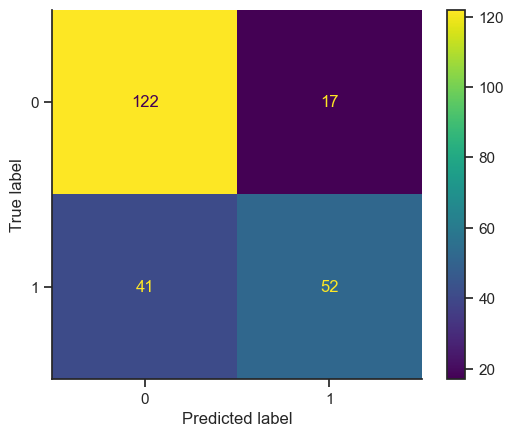

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       555
           1       0.73      0.66      0.69       370

    accuracy                           0.77       925
   macro avg       0.76      0.75      0.75       925
weighted avg       0.76      0.77      0.76       925


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       139
           1       0.75      0.56      0.64        93

    accuracy                           0.75       232
   macro avg       0.75      0.72      0.72       232
weighted avg       0.75      0.75      0.74       232



In [197]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

### KNN

In [198]:
x_train, x_test, y_train, y_test = create_train(knn_features, target)

model = create_model(KNeighborsClassifier(n_neighbors = 3), knn_features)
model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

results['KNN'].append(cross_val_score(model, features, target, cv=5, scoring='recall'))

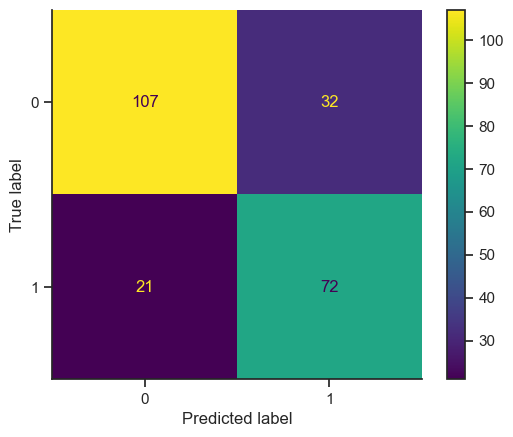

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       555
           1       0.85      0.92      0.89       370

    accuracy                           0.91       925
   macro avg       0.90      0.91      0.90       925
weighted avg       0.91      0.91      0.91       925


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       139
           1       0.69      0.77      0.73        93

    accuracy                           0.77       232
   macro avg       0.76      0.77      0.77       232
weighted avg       0.78      0.77      0.77       232



In [199]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

### Random Forest

In [200]:
x_train, x_test, y_train, y_test = create_train(random_forest_features, target)

model = create_model(
    RandomForestClassifier(n_estimators = 100, min_samples_split = 2, min_samples_leaf = 1, max_depth = 9, criterion = 'gini', n_jobs=-1, random_state=42), 
    random_forest_features
)
model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

results['RandomForest'].append(cross_val_score(model, features, target, cv=5, scoring='recall'))

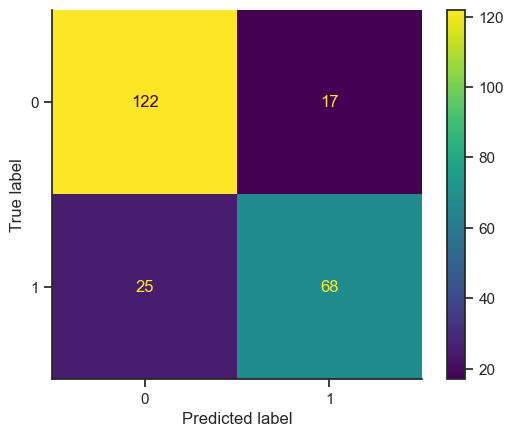

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       555
           1       0.93      0.84      0.88       370

    accuracy                           0.91       925
   macro avg       0.92      0.90      0.91       925
weighted avg       0.91      0.91      0.91       925


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       139
           1       0.80      0.73      0.76        93

    accuracy                           0.82       232
   macro avg       0.81      0.80      0.81       232
weighted avg       0.82      0.82      0.82       232



In [201]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_)

display_cm.plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')

## Análise de resultados com validação cruzada

In [202]:
result = pd.DataFrame.from_dict(results, orient='index', columns=['Original', 'Feature Selection', 'Final'])

In [209]:
def plot_comparative(result: pd.DataFrame, model_name: str, ax: plt.Axes) -> None:
    data = pd.DataFrame([result.loc[model_name, 'Original'], result.loc[model_name, 'Feature Selection'], result.loc[model_name, 'Final']], index=['Original', 'Feature Selection', 'Final']).T
    sns.lineplot(data=data, marker= 'o', markersize=5, ax=ax)
    ax.set_xlabel('Model')
    ax.set_ylabel('Recall')
    ax.set_title(model_name)
    ax.grid(visible=True, color='black', linewidth=.5)
    fig.tight_layout()

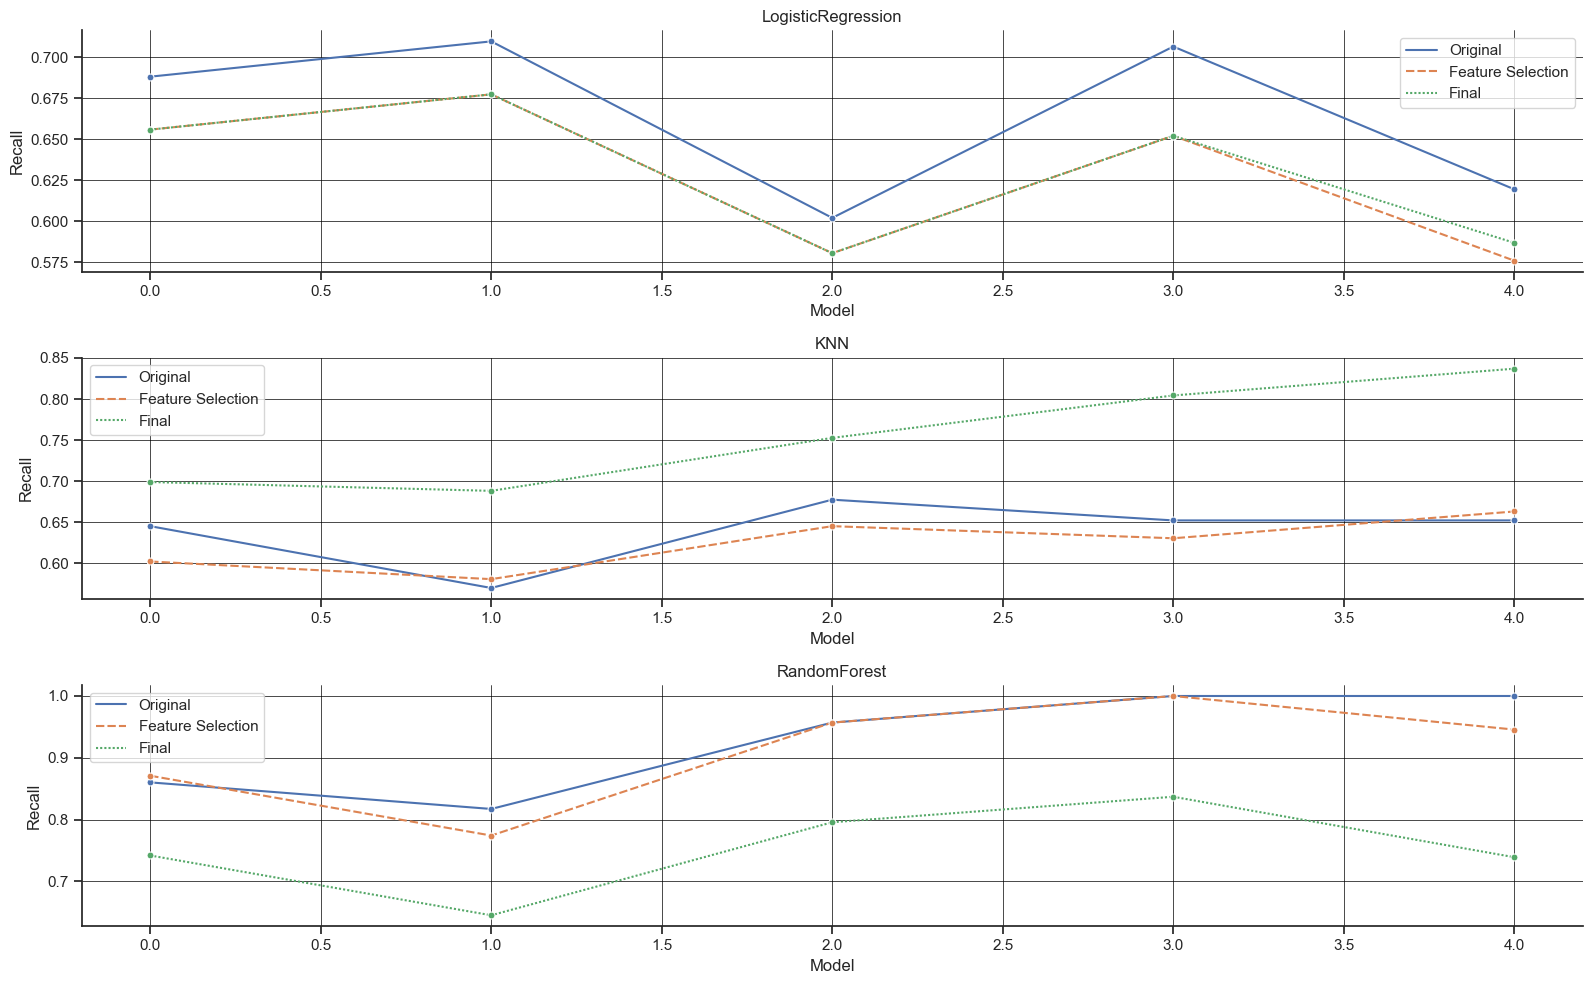

In [210]:
fig = plt.figure(figsize=(16, 10))

for i, model_name in enumerate(result.index):
    ax = plt.subplot(3, 1, i+1)
    plot_comparative(result, model_name, ax)

plt.show()

## Conclusão